# Image captioning model - Tune
Following guide from [HuggingFace: Image captioning](https://huggingface.co/docs/transformers/main/en/tasks/image_captioning)

## Libraries & packages

In [1]:
%env CUDA_VISIBLE_DEVICES=0,1
%env PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:256

env: CUDA_VISIBLE_DEVICES=0,1
env: PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:300


In [2]:
#!pip install transformers datasets evaluate -q
#!pip install jiwer -q
#!pip install transformers[torch]
#!pip install -U accelerate
#!pip install bitsandbytes

In [3]:
import pandas as pd
import csv
import json

from datasets import load_dataset

from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np

from transformers import AutoProcessor
from transformers import AutoModelForCausalLM

from evaluate import load
import torch

from transformers import TrainingArguments, Trainer

from PIL import Image

from huggingface_hub import notebook_login

In [4]:
#notebook_login()

##  Import dataset
Generate a {image-caption} pairs metadata file in JSON format for the model.

In [5]:
# Path to folder with images
img_path = '../Datasets/childrens-books'

# Path to file with images' description
# Original is CSV format
img_path_csv = '../Manual Image captioning/childrens-books-captions-unicode.csv'
# Generated JSON file path
img_path_json = img_path + '/metadata.jsonl'

In [6]:
# Function to convert a CSV to JSON
# Takes the file paths as arguments
def make_json(csvFilePath, jsonFilePath):
     
    # create a list
    data = []
     
    # Open a csv reader called DictReader
    with open(csvFilePath) as csvf:
        csvReader = csv.DictReader(csvf)
         
        # Add each row to data list as dictionary
        for row in csvReader:
            data.append(row)
 
    # Open a json writer, and use the json.dumps()
    # function to dump data
    with open(jsonFilePath, 'w') as jsonf:
        for item in data:
            jsonf.write(json.dumps(item) + "\n")

In [7]:
# Call the make_json function
# Saves the json file from csv original file
make_json(img_path_csv, img_path_json)

In [8]:
# Load dataset
img_ds = load_dataset('imagefolder', data_dir = img_path)
# Print image dataset info to confirm it was correctly created
img_ds

Resolving data files:   0%|          | 0/1711 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 1710
    })
})

## Split dataset into train & test sets
Split dataset into train and test, test size of 25% of total images.

In [9]:
# Split dataset into train and test, test size of 25% of total images
img_ds_split = img_ds['train'].train_test_split(test_size=0.25)
train_ds = img_ds_split['train']
test_ds = img_ds_split['test']

In [10]:
# Function to plot images
def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis('off')

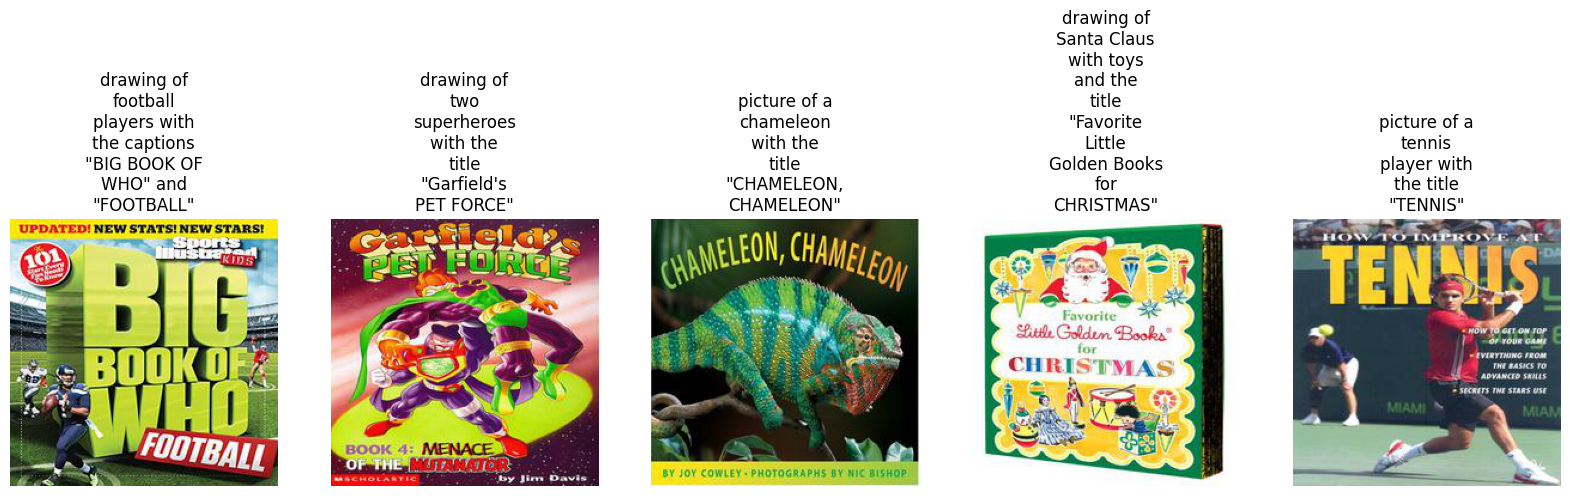

In [11]:
# Print some images from train dataset
sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

## Preprocess dataset
Since the dataset has two modalities (image and text), the pre-processing pipeline will preprocess images and the captions.

In [12]:
# Load the processor class associated with the model we are about to fine-tune
checkpoint = 'microsoft/git-base-coco'
processor = AutoProcessor.from_pretrained(checkpoint)

The processor will internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.

In [13]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs

In [14]:
# Process train and test datasets
train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

## Load a base model
Load the “microsoft/git-large-r-coco” into a AutoModelForCausalLM object.

In [15]:
model = AutoModelForCausalLM.from_pretrained(checkpoint)

## Define evaluation type
Image captioning models are typically evaluated with the Rouge Score or Word Error Rate. We will use the **Word Error Rate (WER)**.

**Limitation of WER:** provides no details on the nature of translation errors and further work is therefore required to identify the main source(s) of error and to focus any research effort.

In [16]:
# Load WER 
wer = load("wer")

In [17]:
# Function to evaluate with WER
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

## Train model

Define the training arguments using TrainingArguments.

In [18]:
# Get base model name
model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-childrensbooks",
    label_names=["labels"],
    
    fp16=True,    # For GPU only
    #auto_find_batch_size=True,
    optim="adamw_bnb_8bit",
    gradient_checkpointing=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    
    learning_rate=2e-4,
    num_train_epochs=10,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=10,
    save_strategy="steps",
    save_steps=10,
    logging_steps=10,
    remove_unused_columns=False,
    
    #push_to_hub=True,
    load_best_model_at_end=True
)

Pass the arguments along with the datasets and the model to Trainer.

In [19]:
import bitsandbytes as bnb
from torch import nn
from transformers.trainer_pt_utils import get_parameter_names

decay_parameters = get_parameter_names(model, [nn.LayerNorm])
decay_parameters = [name for name in decay_parameters if "bias" not in name]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if n in decay_parameters],
        "weight_decay": training_args.weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
        "weight_decay": 0.0,
    },
]

optimizer_kwargs = {
    "betas": (training_args.adam_beta1, training_args.adam_beta2),
    "eps": training_args.adam_epsilon,
}
optimizer_kwargs["lr"] = training_args.learning_rate
adam_bnb_optim = bnb.optim.Adam8bit(
    optimizer_grouped_parameters,
    betas=(training_args.adam_beta1, training_args.adam_beta2),
    eps=training_args.adam_epsilon,
    lr=training_args.learning_rate,
)

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    optimizers=(adam_bnb_optim, None)
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [21]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [22]:
# Train the model
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 22.49 GiB. GPU 0 has a total capacty of 47.54 GiB of which 22.32 GiB is free. Process 60475 has 25.22 GiB memory in use. Of the allocated memory 23.50 GiB is allocated by PyTorch, and 288.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Inference

In [31]:
# Function to prepare image for the model and caption it
def caption_image(img_path):
    # Prepare image for the model
    image = Image.open(img_path)
    
    # Call generate and decode the predictions
    device = "cuda" if torch.cuda.is_available() else "cpu"

    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values
    
    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # Return image and caption
    return image, generated_caption

In [34]:
# Define a list of images
imgs_validation = ['0545077974.jpg','0545533643.jpg','0545834910.jpg','0553508504.jpg','0670887102.jpg']

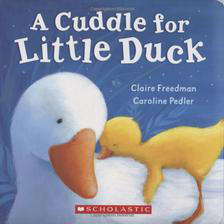

Generated caption:  children's drawing of a yellow dog with the title " a little duck "




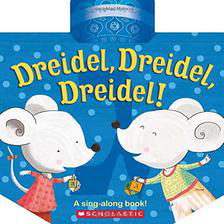

Generated caption:  children's drawing of two dogs wearing clothes around the title " charlie the dog "




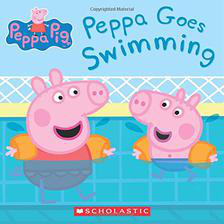

Generated caption:  children's drawing of two pigs with the caption " charlie the piggy "




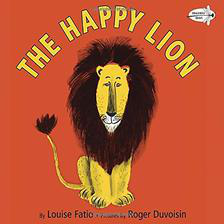

Generated caption:  children's drawing of a yellow lion with the caption " the happy lion "




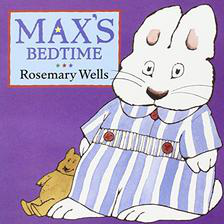

Generated caption:  children's drawing of a dog wearing a white shirt and the caption " charlie's bedtime "




In [38]:
# Caption test images
for img in imgs_validation:
    image, generated_caption = caption_image(img)
    image.show()
    print('\033[1mGenerated caption: \033[0m',generated_caption)
    print('\n')